In [1]:
#
# Uses a simple surface simulator and waveform tracker to investigate
# effects of wave groups on retrieved wave heights. 
# First created in Matlab by F. Ardhuin     2021/09/15
# Adpatation to python:      M. de Carlo    2022/04/07
#

from matplotlib import pyplot as plt
import numpy as np
from simulator_functions import *
from altimetry_processing_functions import *
import warnings

warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})

In [2]:
# In this first example we define the wave spectrum direcly on the kx,ky grid 
# that is the Fourier transform of the x,y grid we want for the sea surface

# X, Y : grid of wavenumbers = 2 * pi /wavelength
# steps : dkx and dky, with nx and ny values. dkx = 2*pi/(dx*nx)
# x, y : grid of real x,y : nx values with a dx step. 
noise= 0
## ---  physical surface definition
# size of simulated sea surface in x and y
nx = 2048
ny = 2048
dx = 10 # [m]
dy = 10 # [m]

## --- read_spectra
theta_m=90
D=2000
T0=16
Hs = 4

kp=2*np.pi/400;sx=kp*0.1;sy=sx;

Z1, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,Hs=Hs,
                         sk_theta=0.001,sk_k=0.001,typeSpec='Gaussian')

# Z1, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,
#                                       nk=1001,nth=36,klims=(0.0002,0.2),n=4,typeSpec='PM')

S1,x,y= surface_from_Z1kxky(Z1,kX,kY) # This function contains the random operator of phases

Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  3.999999999999996


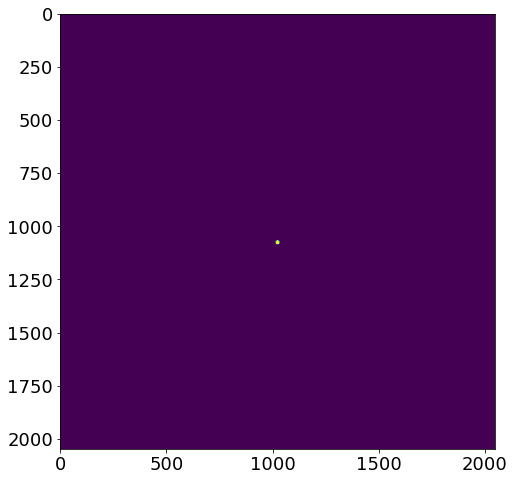

In [3]:
np.sum(Z1)
fig,ax=plt.subplots(figsize=(8,8))
plt.imshow(np.fliplr(np.transpose(Z1)),vmin=0, vmax=10000)


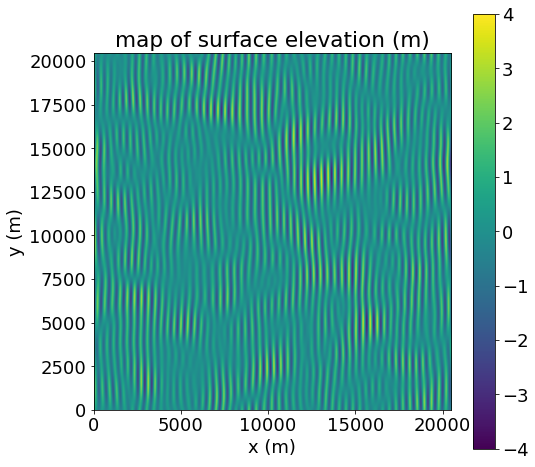

In [4]:
# For checking: let us now read matlab surface ... 
fig,ax=plt.subplots(figsize=(8,8))
img=plt.imshow(np.flipud(S1),vmin=-4, vmax=4,extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('map of surface elevation (m)')
fig.colorbar(img)

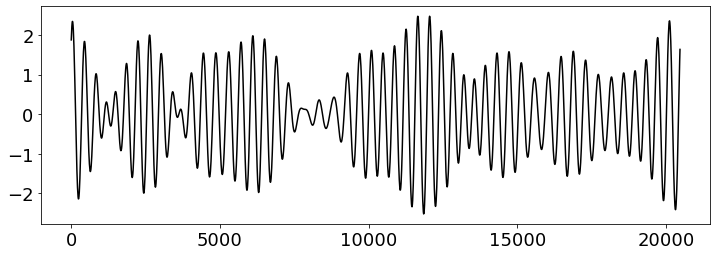

In [5]:
np.var(S1)
fig,ax=plt.subplots(figsize=(12,5))
plt.plot(x,S1[1023,:],'k-')
plt.xlabel('x (m)')
plt.ylabel('surface elevation (m)')
plt.title('transect of surface elevation')

In [6]:
freq_satsampl=40 # freq for waveforms
v_sat=7000 # satellite velocity in m/s
alti_sat=519000 # altitude of satellite CFOSAT
# WARNING: the following 4 parameters should probably be adjusted as a function of the wave height ... 
radi = 4000     # radius used to compute waveform
radi1 = 900     # inner radius for Hs average
radi2 = 1200    # outer radius for Hs average
range_shift = 10 # shift of the waveforms from the "epoch" in meters

isplot_steps=0
# --- edges for range windows ------------
dr = 0.4
edges_max = 20

nHs=251
Hs_max = 25

wfm_ref, Hsm_ref, edges_ref = generate_wvform_database(dr,nHs,edges_max=edges_max,Hs_max=Hs_max,offset=range_shift)

nxa=np.floor(radi/dx).astype(int) # size of radius of footprint in pixel
di=np.floor((v_sat/freq_satsampl)/dx).astype(int) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)
nsamp=np.floor((nx-2*nxa)/di).astype(int) # Nb of samples

Hs_std,Hs_std2,Hs_retrack,Xalt,waveforms,surf1 = fly_over_track_v0(x,y,S1,nsamp,nxa,di,wfm_ref,Hsm_ref,edges_ref,radi,radi1,radi2,alti_sat,range_shift)


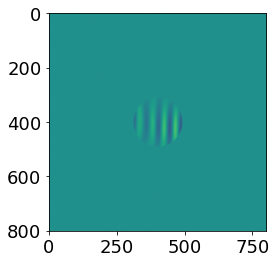

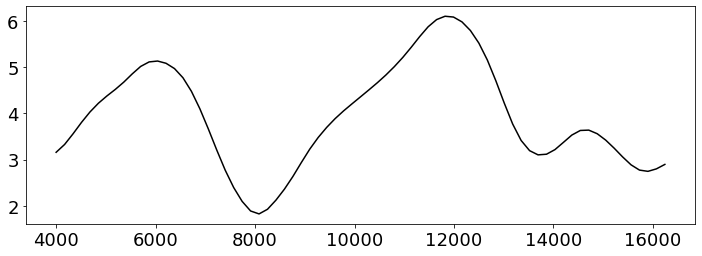

In [7]:
plt.imshow(np.flipud(surf1),vmin=-4, vmax=4)

fig,ax=plt.subplots(figsize=(12,4))
plt.plot(Xalt,Hs_std,color='k',label='python')


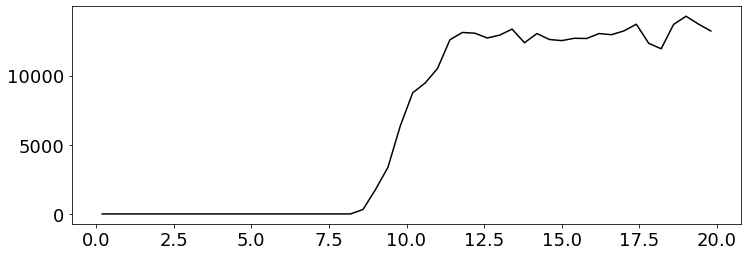

In [8]:

fig,ax=plt.subplots(figsize=(12,4))
plt.plot(edges_ref[0:-1]+dr/2,waveforms[0,:],color='k',label='python')


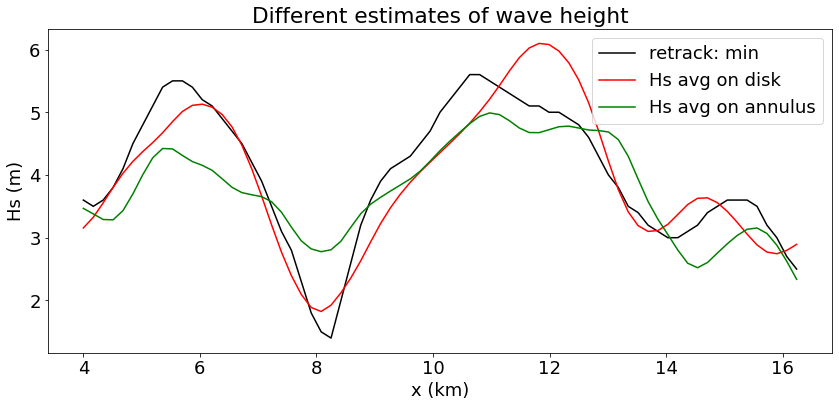

In [14]:
fig,ax=plt.subplots(figsize=(12,6))
line1=plt.plot(Xalt*0.001, Hs_retrack, color='k',label='retrack: min')
line2=plt.plot(Xalt*0.001, Hs_std, color='r',label='Hs avg on disk')
line3=plt.plot(Xalt*0.001, Hs_std2, color='g',label='Hs avg on annulus')
plt.grid
plt.xlabel('x (km)')
plt.ylabel('Hs (m)')
plt.title('Different estimates of wave height')
leg = plt.legend(loc='upper right')
plt.show()